# American options


## Contents
   - [Binomial tree](#sec1)
   - [Longstaff - Schwartz](#sec2)
   
   
The American option problem is an optimal stopping problem formulated as follows:

$$ V(t,s) =  \sup_{\tau \in [t,T]} \mathbb{E}^{\mathbb{Q}}\biggl[ e^{-r(T-\tau)} \Phi(S_{\tau}) \bigg| S_t=s \biggr]$$

where $\Phi(\cdot)$ is the payoff, also called *intrinsic value*.    
This formula resembles the formula of a European option, except that in this case the option can be exercised at any time. But... at which time? The problem is to find the best exercise time $\tau$ that maximizes the expectation.

Notice that the time $\tau$ is a random variable! It can be different for different paths of the stock process.   
The solution of the problem provides a strategy, that at each time assesses if it is optimal to exercise the option or not, depending on the current value of the underlying stock.

This notebook is dedicated only to the pricing problem, i.e. just to find $V(t,s)$, and not to find $\tau$.

It can be proved that the function $V(t,s)$ is the (weak) solution of the following PDE:

\begin{equation}
\max \biggl\{  \frac{\partial  V(t,s)}{\partial t}  
          + r\,s \frac{\partial V(t,s)}{\partial s}
          + \frac{1}{2} \sigma^2 s^2 \frac{\partial^2  V(t,s)}{\partial s^2} - r  V(t,s), \;  
          \Phi(s) - V(t,s) \biggr\}  = 0.
\end{equation}

$$ V(T,s) = \Phi(s) $$

The numerical algorithm for solving this PDE is almost identical to the algorithm proposed in the notebook **2.1** for the Black-Scholes PDE. 

Let us have a look at the differences between the implementation of the European and the American algorithm, in the class `BS_pricer`:

```python
if self.exercise=="European":        
    for i in range(Ntime-2,-1,-1):
        offset[0] = a * V[0,i]  
        offset[-1] = c * V[-1,i]
        V[1:-1,i] = spsolve( D, (V[1:-1,i+1] - offset) )
elif self.exercise=="American":
    for i in range(Ntime-2,-1,-1):
        offset[0] = a * V[0,i]
        offset[-1] = c * V[-1,i]
        V[1:-1,i] = np.maximum( spsolve( D, (V[1:-1,i+1] - offset) ), Payoff[1:-1])
```

The European and the American algorithms just differ in one line!!    

I don't consider dividends in the notebook. In absence of dividends the American call has the same value of the European call. For this reason, I'm going to consider only the pricing problem of a put option

$$ \Phi(S_{\tau}) = ( K - S_{\tau} )^+ $$


In [1]:
from functions.BS_pricer import BS_pricer
from functions.Parameters import Option_param
from functions.Processes import Diffusion_process

import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import sympy; sympy.init_printing()

def display_matrix(m):
    display(sympy.Matrix(m))

In [5]:
# Creates the object with the parameters of the option
opt_param = Option_param(S0=100, K=100, T=1, exercise="American", payoff="put" )
# Creates the object with the parameters of the process
diff_param = Diffusion_process(r=0.1, sig=0.2)
# Creates the pricer object
BS = BS_pricer(opt_param, diff_param)

The class `BS_pricer` implements two algorithms to price American options:
- the Longstaff-Schwartz Method (see section [below](#sec2))
- the PDE method

In [24]:
BS.LSM(N=10000, paths=10000, order=2)  # Longstaff Schwartz Method

In [4]:
BS.PDE_price((7000,5000))

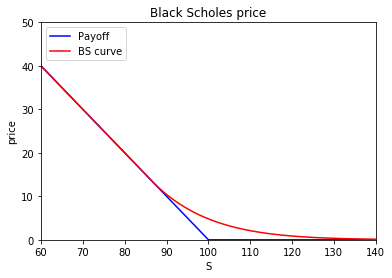

In [10]:
BS.plot([60,140,0,50])

<a id='sec1'></a>
## Binomial tree

One of the most used methods for pricing American options is the Binomial tree. 

We have already encountered the binomial tree in the notebook **1.1**. The following algorithm is almost a copy/paste from that notebook.     
There are just two additional lines:
- `S_T = S_T * u`. This an efficient method to retrive the price vector at each time steps.  
- `V = np.maximum( V, K-S_T )`. This line computes the maximum between the conditional expectation V and the intrisic value. 

In [2]:
S0=100.0    # spot stock price
K=100.0     # strike
T=1.0       # maturity 
r=0.1       # risk free rate 
sig=0.2     # diffusion coefficient or volatility

In [15]:
N = 25000              # number of periods or number of time steps  
payoff = "put"        # payoff 

dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

V = np.zeros(N+1)                             # initialize the price vector
S_T = np.array( [(S0 * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T

a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability   

if payoff =="call":
    V[:] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:] = np.maximum(K-S_T, 0.0)

for i in range(N-1, -1, -1):
    V[:-1] = np.exp(-r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
    S_T = S_T * u                    # it is a tricky way to obtain the price at the previous time step
    if payoff=="call":
        V = np.maximum( V, S_T-K )
    elif payoff=="put":
        V = np.maximum( V, K-S_T )
    
print("American BS Tree Price: ", V[0])

American BS Tree Price:  4.81624866310944


<a id='sec2'></a>
## Longstaff - Schwartz Method

This is a Monte Carlo algorithm proposed by Longstaff and Schwartz in the paper [1]:
[LS Method](https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf)

The algorithm is not difficult to implement, but it can be difficult to understand.  I think this is the reason the authors started the paper with an example.    
Well. I think they had a good idea, and for this reason I want to reproduce their example here. 

The same code is copied in the class `BS_pricer` where the function `LSM` is implemented.

**If in the following code you feel that something is unclear, I suggest you to follow the steps (not in python) proposed in the original paper**.

In [6]:
N = 4          # number of time steps
r = 0.06       # interest rate
K = 1.1        # strike 
T = 3          # Maturity

dt = T/(N-1)          # time interval
df = np.exp(-r * dt)  # discount factor per time interval

In [9]:
S = np.array([
            [1.00, 1.09, 1.08, 1.34],
            [1.00, 1.16, 1.26, 1.54],
            [1.00, 1.22, 1.07, 1.03],
            [1.00, 0.93, 0.97, 0.92],
            [1.00, 1.11, 1.56, 1.52],
            [1.00, 0.76, 0.77, 0.90],
            [1.00, 0.92, 0.84, 1.01],
            [1.00, 0.88, 1.22, 1.34]])

In [10]:
display_matrix(S)

⎡1.0  1.09  1.08  1.34⎤
⎢                     ⎥
⎢1.0  1.16  1.26  1.54⎥
⎢                     ⎥
⎢1.0  1.22  1.07  1.03⎥
⎢                     ⎥
⎢1.0  0.93  0.97  0.92⎥
⎢                     ⎥
⎢1.0  1.11  1.56  1.52⎥
⎢                     ⎥
⎢1.0  0.76  0.77  0.9 ⎥
⎢                     ⎥
⎢1.0  0.92  0.84  1.01⎥
⎢                     ⎥
⎣1.0  0.88  1.22  1.34⎦

In the previous cell we defined the stock matrix S.   
It has 8 rows that correspond to the number of paths.  
The 4 columns correspond to the 4 time steps, i.e. each row is a path with 4 time steps.

In [13]:
H = np.maximum(K - S, 0)           # intrinsic values for put option
V = np.zeros_like(H)               # value matrix
V[:,-1] = H[:,-1]

# Valuation by LS Method
for t in range(N-2, 0, -1):

    good_paths = H[:,t] > 0        # paths where the intrinsic value is positive 
                                   # the regression is performed only on these paths 
    
    rg = np.polyfit( S[good_paths, t], V[good_paths, t+1] * df, 2)    # polynomial regression
    C = np.polyval( rg, S[good_paths,t] )                             # evaluation of regression  
    
    exercise = np.zeros( len(good_paths), dtype=bool)    # initialize
    exercise[good_paths] = H[good_paths,t] > C           # paths where it is optimal to exercise
    
    V[exercise,t] = H[exercise,t]                        # set V equal to H where it is optimal to exercise 
    V[exercise,t+1:] = 0                                 # set future cash flows, for that path, equal to zero  
    discount_path = (V[:,t] == 0)                        # paths where we didn't exercise 
    V[discount_path,t] = V[discount_path,t+1] * df       # set V[t] in continuation region
    
V0 = np.mean(V[:,1]) * df  # discounted expectation of V[t=1]
print("Example price= ", V0)

Example price=  0.11443433004505696


The matrix `H = np.maximum(K - S, 0)`, is the matrix of intrinsic values:

In [15]:
display_matrix(H.round(2))

⎡0.1  0.01  0.02  0.0 ⎤
⎢                     ⎥
⎢0.1  0.0   0.0   0.0 ⎥
⎢                     ⎥
⎢0.1  0.0   0.03  0.07⎥
⎢                     ⎥
⎢0.1  0.17  0.13  0.18⎥
⎢                     ⎥
⎢0.1  0.0   0.0   0.0 ⎥
⎢                     ⎥
⎢0.1  0.34  0.33  0.2 ⎥
⎢                     ⎥
⎢0.1  0.18  0.26  0.09⎥
⎢                     ⎥
⎣0.1  0.22  0.0   0.0 ⎦

The matrix V contains the cash flows.

**Important**    
To simplify the computations, the discounted cashflows are reported at every time steps. 

For instance:    
In the third row the final cashflow (0.07) is discounted at every time step, till t=1.    
In the paper, the authors just consider the cashflow (0.07) at time t=3 and the discount is performed at the end of the algorithm.

In [18]:
display_matrix(V.round(4))

⎡0.0   0.0     0.0    0.0 ⎤
⎢                         ⎥
⎢0.0   0.0     0.0    0.0 ⎥
⎢                         ⎥
⎢0.0  0.0621  0.0659  0.07⎥
⎢                         ⎥
⎢0.0   0.17    0.0    0.0 ⎥
⎢                         ⎥
⎢0.0   0.0     0.0    0.0 ⎥
⎢                         ⎥
⎢0.0   0.34    0.0    0.0 ⎥
⎢                         ⎥
⎢0.0   0.18    0.0    0.0 ⎥
⎢                         ⎥
⎣0.0   0.22    0.0    0.0 ⎦

## References

[1] F. Longstaff, E. Schwartz (2001) "Valuing American Options by Simulation: A Simple Least-Squares Approach", The Review of Financial Studies, vol 14-1, pag 113-147.   